In [1]:
import pylab 
import pycbc.noise
import pycbc.psd
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
#import os
import numpy as np
import lensid.utils.qt_utils as qt

In [2]:
hp,hc = get_td_waveform(approximant = "IMRPhenomPv2",mass1=130,mass2=120,\
                        inclination=np.pi/4,delta_t=1.0/2**12,f_lower=15,f_higher = 1000, \
                        distance =600,coa_phase = np.pi/3)
det_h1 = Detector("H1")

In [3]:
end_time, declination, right_ascension, polarization = 689913918.0, -1.12, 2.73, 5.25


hp.start_time += end_time
hc.start_time +=end_time

signal = det_h1.project_wave(hp,hc,right_ascension,declination,polarization)
t_gps=end_time

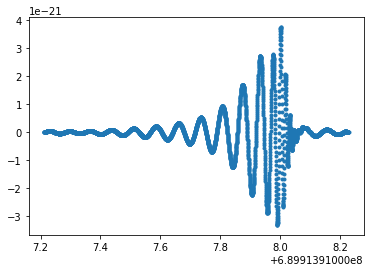

In [4]:
pylab.plot(signal.sample_times,signal.data,'.')
pylab.show()

In [13]:
flow = 0
#delta_f = 1.0 / 16
#flen = int(2048 / delta_f) + 1
#psd_H = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

delta_f = 1.0/16#signal.sample_rate / float(len(signal))
flen = int(signal.sample_rate / (2 * delta_f)) + 1
psd_H = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)


#### Changing flow to 0 from 15 earlier, solved the issue of weird QTs for injections.

In [14]:
def inject_noise_signal_custom(signal, psd, duration=128, whitened=False, seed=None):
    """
    Adds gaussian noise to a given signal using a given PSD. Optionally whitens the signal.

    Parameters:

        signal: input pycbc types timeseries.
        
        psd: powers spectral density to generate noise realisation from.
        
        duration(int): duration of the output noise signal, only if
            whitened = True, default =128s.
        whitened(bool): whiten the signal True/False(default).
        
        seed(int): random seed for the noise realisation, default: None.

    Returns:
        pycbc timeseries: noise_signal of 8s.

    """
    delta_t = 1.0 / signal.sample_rate
    tsamples = int(duration / delta_t)

    ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=seed)
    ts.start_time += signal.end_time - duration / 2
    noise_signal = ts.add_into(signal)
    if whitened == True:

        noise_signal_whitened = (
            noise_signal.whiten(4,4) * 1e-21
        )
        return noise_signal_whitened.time_slice(
            signal.end_time - 6, signal.end_time + 2
        )
    else:
        return noise_signal.time_slice(
            signal.end_time - 6, signal.end_time + 2
        )

In [15]:
noise_signal = inject_noise_signal_custom(signal, psd_H,whitened=False,seed=10)
noise_signal_whitened = inject_noise_signal_custom(signal, psd_H,whitened=True,seed=10)


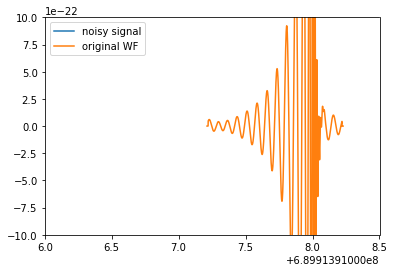

In [16]:
#pylab.plot(noise_signal_whitened.sample_times,noise_signal_whitened.data, label='whitened signal')
pylab.plot(noise_signal.sample_times,noise_signal.data,label='noisy signal')
pylab.plot(signal.sample_times,signal.data,label='original WF')
pylab.xlim(t_gps-2,t_gps+0.5)
pylab.ylim(-1E-21,1E-21)
pylab.legend()
pylab.show()

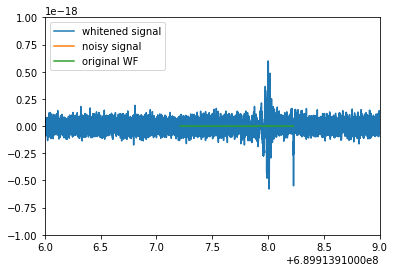

In [17]:
pylab.plot(noise_signal_whitened.sample_times,noise_signal_whitened.data, label='whitened signal')
pylab.plot(noise_signal.sample_times,noise_signal.data,label='noisy signal')
pylab.plot(signal.sample_times,signal.data,label='original WF')
pylab.xlim(t_gps-2,t_gps+1)
pylab.ylim(-1E-18,1E-18)

pylab.legend()
pylab.show()

In [18]:
ids=np.where(psd_H>0)[0]
hf_whitened=noise_signal.to_frequencyseries(delta_f=delta_f)
hf_whitened.data=hf_whitened.data[ids]/psd_H[ids]**0.5
h_whitened=hf_whitened.to_timeseries()*1E-21

In [19]:
psd_H[0] = psd_H[1]
psd_H[len(psd_H) - 1] = psd_H[len(psd_H) - 2]
hf1_whitened = (noise_signal.to_frequencyseries(delta_f=delta_f) / psd_H**0.5).to_timeseries() * 1E-21

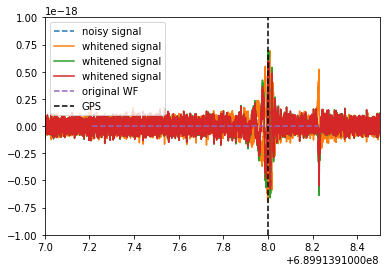

In [23]:
pylab.plot(noise_signal.sample_times,noise_signal.data,'--',label='noisy signal')
pylab.plot(h_whitened.sample_times,h_whitened.data,'-', label='whitened signal')
pylab.plot(hf1_whitened.sample_times,hf1_whitened.data,'-', label='whitened signal')
pylab.plot(noise_signal_whitened.sample_times,noise_signal_whitened.data,'-', label='whitened signal')

pylab.plot(signal.sample_times,signal.data,'--',label='original WF')
pylab.axvline(t_gps,ls='dashed', color='k',label='GPS')
pylab.xlim(t_gps-1,t_gps+0.5)
pylab.ylim(-1E-18,1E-18)
pylab.legend()
pylab.show()

/home/srashti.goyal/.local/lib/python3.7/site-packages/lensid/utils/qt_utils.py:130: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cmap="viridis",
/home/srashti.goyal/.local/lib/python3.7/site-packages/lensid/utils/qt_utils.py:140: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pylab.yscale("log", basey=2)


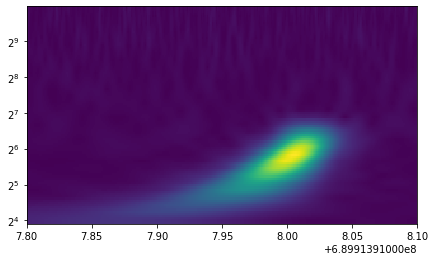

In [24]:
max_power=qt.plot_qt_from_ts(noise_signal, t_gps, (3,30) , outfname='',save=False)

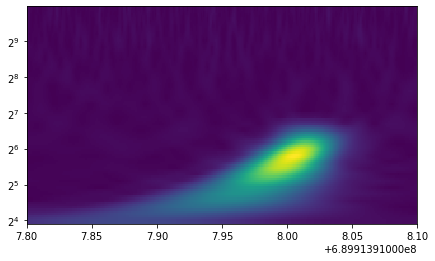

In [25]:
max_power=qt.plot_qt_from_ts(noise_signal_whitened, t_gps, (3,80) , outfname='',save=False)

In [30]:
psd_H_o3,psd_L_o3,psd_V_o3= qt.inj_psds_HLV(psd_mode='load',asd_dir='../data/PSDs/O3a_representative_psd')

In [31]:
noise_signal_o3 = inject_noise_signal_custom(signal, psd_H_o3,whitened=False,seed=10)
noise_signal_whitened_o3 = inject_noise_signal_custom(signal, psd_H_o3,whitened=True,seed=10)


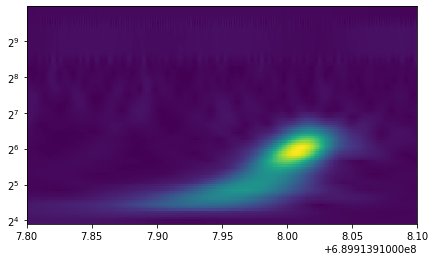

In [32]:
max_power=qt.plot_qt_from_ts(noise_signal_o3, t_gps, (3,30) , outfname='',save=False)

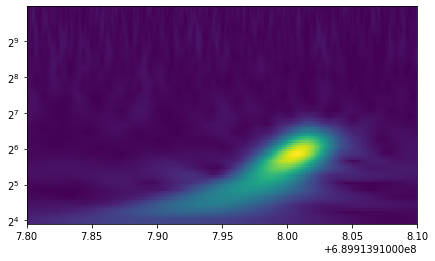

In [33]:
max_power=qt.plot_qt_from_ts(noise_signal_whitened_o3, t_gps, (3,30) , outfname='',save=False)